In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('results_apr25.csv')
df

,prompt_type,n_shots,transcript_type,concat_fewshot,concat_test,two_turns,aggregate_fewshot,balanced_accuracy
0,vanilla,1,none,False,False,False,True,0.581852
1,vanilla,2,none,False,False,False,True,0.531005
2,vanilla,4,none,False,False,False,True,0.609963
3,vanilla,1,none,False,True,False,True,0.526664
4,vanilla,2,none,False,True,False,True,0.537826
...,...,...,...,...,...,...,...,...
283,structured,4,asr,False,True,False,False,0.503100
284,structured,0,asr,False,False,True,False,0.517363
285,structured,1,asr,False,False,True,False,0.493692
286,structured,2,asr,False,False,True,False,0.488218


### 1.1) Does simple prompting with in-context learning work?

In [4]:
# i want to filter the dataframe to only include rows where the 'transcript_type' column is 'none'
mask = (
    # (df['n_shots'] == 0) &
    (df['transcript_type'] == 'none') &
    (df['concat_fewshot'] == False) &
    (df['concat_test']   == False) &
    (df['two_turns']  == False) &
    (df['aggregate_fewshot'] == False)
)
print("len:", len(df[mask]))
# df[mask]
df_baseline = df[mask]
df_baseline

len: 16


,prompt_type,n_shots,transcript_type,concat_fewshot,concat_test,two_turns,aggregate_fewshot,balanced_accuracy
12,vanilla,0,none,False,False,False,False,0.521910
13,vanilla,1,none,False,False,False,False,0.527284
14,vanilla,2,none,False,False,False,False,0.498760
15,vanilla,4,none,False,False,False,False,0.535345
84,standard_cot,0,none,False,False,False,False,0.541753
85,standard_cot,1,none,False,False,False,False,0.477677
86,standard_cot,2,none,False,False,False,False,0.489872
87,standard_cot,4,none,False,False,False,False,0.565110
156,comprehensive_cot,0,none,False,False,False,False,0.492766
157,comprehensive_cot,1,none,False,False,False,False,0.528317


### 1.2) Audio–specific Prompt–Engineering Strategies

In [5]:
# two_turns:
# two_turns = True | aggregate_fewshot = False | concat_fewshot = False | concat_test = False
# aggregate_fewshot:
# two_turns = False | aggregate_fewshot = True | concat_fewshot = False | concat_test = False
# aggregate_fewshot + concat_test:
# two_turns = False | aggregate_fewshot = True | concat_fewshot = False | concat_test = True
# concat_fewshot:
# two_turns = False | aggregate_fewshot = False| concat_fewshot = True  | concat_test = False
# oneturn:
# two_turns = False | aggregate_fewshot = False| concat_fewshot = False | concat_test = False

In [6]:
mask = (
    # (df['prompt_type'] == 'standard_cot') &
    (df['transcript_type']   == 'none') &
    (df['concat_fewshot']    == True) &
    (df['aggregate_fewshot'] == False) &
    (df['two_turns']         == False) &
    (df['concat_test']       == False) 
)
print("len1:", len(df[mask]))
# averaging over all prompt_type
avg_perf = (
    df[mask].groupby(["n_shots"])["balanced_accuracy"]
      .mean()
      .reset_index()
)
print("len2:", len(avg_perf))
avg_perf

len1: 12
len2: 3


,n_shots,balanced_accuracy
0,1,0.477879
1,2,0.477108
2,4,0.478348


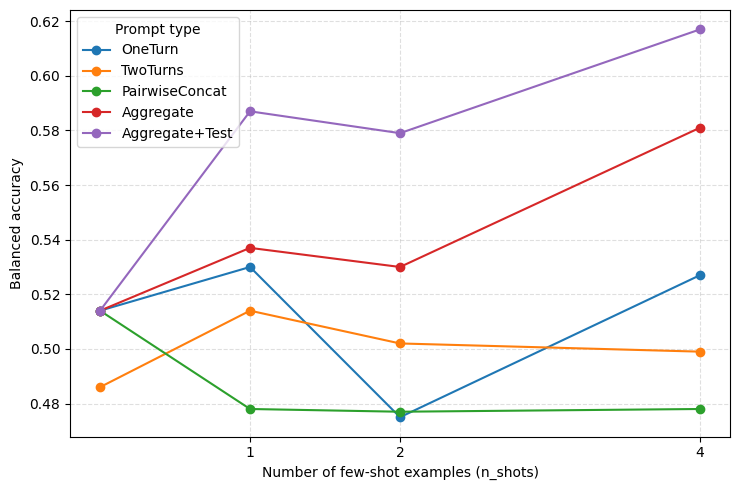

In [7]:
nshots = [0, 1, 2, 4]
oneturn  = [0.514, 0.530, 0.475, 0.527]
twoturns = [0.486, 0.514, 0.502, 0.499]

pairconcat     = [0.514, 0.478, 0.477, 0.478]
aggregate      = [0.514, 0.537, 0.530, 0.581]
aggregate_plus = [0.514, 0.587, 0.579, 0.617]

plt.figure(figsize=(7.5,5))
plt.plot(nshots, oneturn, marker='o', label='OneTurn')
plt.plot(nshots, twoturns, marker='o', label='TwoTurns')
plt.plot(nshots, pairconcat, marker='o', label='PairwiseConcat')
plt.plot(nshots, aggregate, marker='o', label='Aggregate')
plt.plot(nshots, aggregate_plus, marker='o', label='Aggregate+Test')

plt.xlabel("Number of few-shot examples (n_shots)")
plt.ylabel("Balanced accuracy")
plt.xticks(sorted(avg_perf["n_shots"].unique()))
# plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Prompt type")
plt.tight_layout()
plt.savefig("audio_prompt_engineering.pdf", bbox_inches="tight")
plt.show()

### 1.3) Re-visiting Prompting with In-Context Learning using Audio Aggregation

In [8]:
mask = (
    # (df['prompt_type'] == 'standard_cot') &
    (df['transcript_type']   == 'none') &
    (df['concat_fewshot']    == False) &
    (df['aggregate_fewshot'] == True) &
    (df['two_turns']         == False) &
    (df['concat_test']       == True) 
)
print("len1:", len(df[mask]))
# averaging over all prompt_type
avg_perf = (
    df[mask].groupby(["prompt_type", "n_shots"])["balanced_accuracy"]
      .mean()
      .reset_index()
)
print("len2:", len(avg_perf))
avg_perf

len1: 12
len2: 12


,prompt_type,n_shots,balanced_accuracy
0,comprehensive_cot,1,0.540926
1,comprehensive_cot,2,0.566350
2,comprehensive_cot,4,0.594461
3,standard_cot,1,0.615750
4,standard_cot,2,0.642828
5,standard_cot,4,0.692642
6,structured,1,0.664831
7,structured,2,0.568003
8,structured,4,0.648615
9,vanilla,1,0.526664


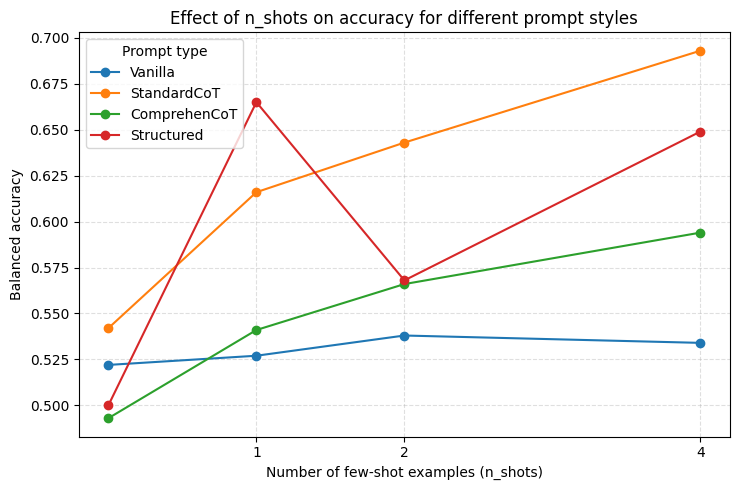

In [ ]:
nshots = [0, 1, 2, 4]
vanilla      = [0.522, 0.527, 0.538, 0.534]
standard_cot = [0.542, 0.616, 0.643, 0.693]
compreh_cot  = [0.493, 0.541, 0.566, 0.594]
structrued   = [0.500, 0.665, 0.568, 0.649]

plt.figure(figsize=(7.5,5))
plt.plot(nshots, vanilla, marker='o', label='Vanilla')
plt.plot(nshots, standard_cot, marker='o', label='StandardCoT')
plt.plot(nshots, compreh_cot, marker='o', label='ComprehenCoT')
plt.plot(nshots, structrued, marker='o', label='Structured')

plt.xlabel("Number of few-shot examples (n_shots)")
plt.ylabel("Balanced accuracy")
# plt.title("Effect of n_shots on accuracy for different prompt styles")
plt.xticks(sorted(avg_perf["n_shots"].unique()))
# plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Prompt type")
plt.tight_layout()
plt.savefig("revisiting_prompt_type_aggregation.pdf", bbox_inches="tight")
plt.show()

### 1.4) Transcription Results

In [18]:
mask = (
    (df['prompt_type'] == 'standard_cot') &
    (df['concat_fewshot']    == False) &
    (df['aggregate_fewshot'] == True) &
    (df['two_turns']         == False) &
    (df['concat_test']       == True) 
)
print("len1:", len(df[mask]))
# averaging over all prompt_type
avg_perf = (
    df[mask].groupby(["transcript_type", "n_shots"])["balanced_accuracy"]
      .mean()
      .reset_index()
)
print("len2:", len(avg_perf))
avg_perf

len1: 9
len2: 9


,transcript_type,n_shots,balanced_accuracy
0,asr,1,0.512609
1,asr,2,0.512609
2,asr,4,0.500413
3,groundtruth,1,0.596527
4,groundtruth,2,0.572137
5,groundtruth,4,0.568417
6,none,1,0.615750
7,none,2,0.642828
8,none,4,0.692642


In [20]:
mask = (
    (df['prompt_type'] == 'standard_cot') &
    (df['n_shots'] == 0) &
    (df['concat_fewshot']    == False) &
    (df['aggregate_fewshot'] == False) &
    (df['two_turns']         == False) &
    (df['concat_test']       == False) 
)
print("len1:", len(df[mask]))
# averaging over all prompt_type
avg_perf = (
    df[mask].groupby(["transcript_type", "n_shots"])["balanced_accuracy"]
      .mean()
      .reset_index()
)
print("len2:", len(avg_perf))
avg_perf

len1: 3
len2: 3


,transcript_type,n_shots,balanced_accuracy
0,asr,0,0.512609
1,groundtruth,0,0.512195
2,none,0,0.541753


# Other investigations

In [37]:
mask = (
    (df['transcript_type'] == 'none')
)
print("len:", len(df[mask]))
avg_perf = (
    df.groupby(["prompt_type", "n_shots"])["balanced_accuracy"]
      .mean()
      .reset_index()
)
print("len:", len(avg_perf))


len: 96
len: 16


In [38]:
# avg_perf

/tmp/ipykernel_2404135/2123394309.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for prompt, grp in avg_perf_sorted.groupby("prompt_type", sort=False):


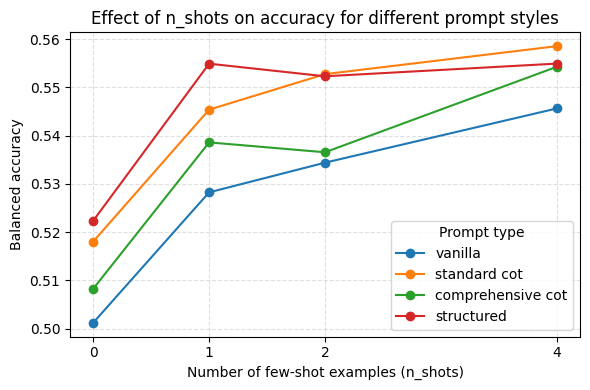

In [39]:
# Desired order
order = ["vanilla", "standard_cot", "comprehensive_cot", "structured"]
# Make the column categorical so Pandas (and Matplotlib) keep that order
avg_perf["prompt_type"] = pd.Categorical(avg_perf["prompt_type"],
                                         categories=order,
                                         ordered=True)
# Sort first by the categorical, then by n_shots
avg_perf_sorted = avg_perf.sort_values(["prompt_type", "n_shots"])
plt.figure(figsize=(6,4))

# NOTE: use sort=False  (not “sorted”)
for prompt, grp in avg_perf_sorted.groupby("prompt_type", sort=False):
    plt.plot(
        grp["n_shots"],
        grp["balanced_accuracy"],
        marker="o",
        label=prompt.replace("_", " ")  # nicer legend labels
    )

plt.xlabel("Number of few-shot examples (n_shots)")
plt.ylabel("Balanced accuracy")
plt.title("Effect of n_shots on accuracy for different prompt styles")
plt.xticks(sorted(avg_perf["n_shots"].unique()))
# plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Prompt type")
plt.tight_layout()
plt.savefig("1_prompt_type_n_shot.pdf", bbox_inches="tight")
plt.show()

In [41]:
# i want to filter the dataframe to only include rows where the 'transcript_type' column is 'none'
mask = (
    (df['n_shots'] == 0) &
    (df['transcript_type'] == 'none') &
    (df['concat_fewshot'] == False) &
    (df['concat_test']   == False) &
    (df['two_turns']  == False) &
    (df['aggregate_fewshot'] == False)
)
print("len:", len(df[mask]))
df[mask]

len: 4


,prompt_type,n_shots,transcript_type,concat_fewshot,concat_test,two_turns,aggregate_fewshot,balanced_accuracy
12,vanilla,0,none,False,False,False,False,0.521910
84,standard_cot,0,none,False,False,False,False,0.541753
156,comprehensive_cot,0,none,False,False,False,False,0.492766
228,structured,0,none,False,False,False,False,0.499587
